Christian Arendt Rasmussen s144466, Frederikke Lehmann s154109 & Clara Foss s154312

# Merging the data from the different genres to one big dataframe

For the purpose of this project in the course 42186 Model-based machine learning F19 , we have chosen to work with data from Spotify. We have extracted the data ourselves using the Spotipy Python library inspired by the Kaggle data set (https://www.kaggle.com/nadintamer/top-tracks-of-2017/version/1). We have around 13200 observations, consisting of random tracks from the genres "pop", "metal", "classical" and "rap", respectively. Each song has a set of audio features, including popularity danceability, energy, tempo, key, etc., and this leads us to our research question:

### Research question
How can the popularity of a Spotify track be predicted with hierarchical regression using the observed audio features, with genre as the level, and how does this compare with a simpler baseline model?

#### Importing packages

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import linear_model
import pystan
import pystan_utils
from sklearn.utils import shuffle
np.random.seed(42)
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (6, 4)
from IPython.display import Image

#### Loading data

In [2]:
#### pop = 1 ####
pop1 = pd.read_csv("SpotifyAudioFeatures2017.csv")
pop2 = pd.read_csv("SpotifyAudioFeatures2018.csv")
pop3 = pd.read_csv("SpotifyAudioFeatures2019.csv")
df_pop = pd.concat([pop1, pop2,pop3])
df_pop["genre"] = [1]*len(df_pop)

#### metal = 2 ####
met1 = pd.read_csv("SpotifyAudioFeatures2017metal.csv")
met2 = pd.read_csv("SpotifyAudioFeatures2018metal.csv")
met3 = pd.read_csv("SpotifyAudioFeatures2019metal.csv")
df_met = pd.concat([met1, met2, met3])
df_met["genre"] = [2]*len(df_met)

#### classical = 3 ####
df_clas = pd.read_csv("SpotifyAudioFeaturesclassical.csv")
df_clas["genre"] = [3]*len(df_clas)

#### rap = 4 ####
rap1 = pd.read_csv("SpotifyAudioFeatures2017rap.csv")
rap2 = pd.read_csv("SpotifyAudioFeatures2018rap.csv")
rap3 = pd.read_csv("SpotifyAudioFeatures2019rap.csv")
df_rap = pd.concat([rap1, rap2, rap3])
df_rap["genre"] = [4]*len(df_rap)

df = pd.concat([df_clas,df_rap,df_pop,df_met])
df = shuffle(df)

In [3]:
print("Shape of pop (1): ", df_pop.shape)
print("Shape of metal (2): ", df_met.shape)
print("Shape of classical (3): ", df_clas.shape) 
print("Shape of rap (4): ",df_rap.shape)
print("Total number of observations: ", df_pop.shape[0]+df_met.shape[0]+df_clas.shape[0]+df_rap.shape[0])

Shape of pop (1):  (6018, 19)
Shape of metal (2):  (5804, 19)
Shape of classical (3):  (5040, 19)
Shape of rap (4):  (5928, 19)
Total number of observations:  22790


#### Removing irrelevant columns and showing the the structure of the data

In [4]:
df_tracks = df
df_tracks = df_tracks.drop(['Unnamed: 0'], axis=1)
df_tracks = df_tracks.dropna(axis = 0)
df_tracks.head()

,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,genre
911,Greta Van Fleet,When The Curtain Falls,2ZMI0QNoqU9fQZFirR9WpK,70,0.029700,0.535,222960,0.9750,0.126000,0,0.0482,-2.959,1,0.0647,96.004,4,0.689,1
819,J. Cole,Power Trip,7FOJvA3PxiIU0DN3JjQ7jT,73,0.322000,0.667,241160,0.6100,0.000203,1,0.4260,-7.054,1,0.2170,99.991,4,0.465,4
4634,Sergei Prokofiev,"Sonata No. 1 in F Minor for Violin and Piano, ...",3IgpUdDBDHFc6oBcFl0m2W,4,0.958000,0.237,406080,0.0744,0.107000,8,0.1050,-22.668,1,0.0399,103.970,4,0.038,3
984,Noah Kahan,Hurt Somebody (With Julia Michaels),7vA2Y79Q4bBqdzBCfHeGEe,77,0.338000,0.633,168640,0.5590,0.000000,6,0.2620,-5.135,1,0.3130,114.983,4,0.473,2
3115,Dream Theater,Dystopian Overture,1NLujLBH0yxoR31ZlvHK7k,43,0.000974,0.272,290880,0.8190,0.851000,4,0.3750,-6.609,1,0.0338,113.290,4,0.195,3


#### Check the number of observations within each genres, before removing duplicates for the entire data set

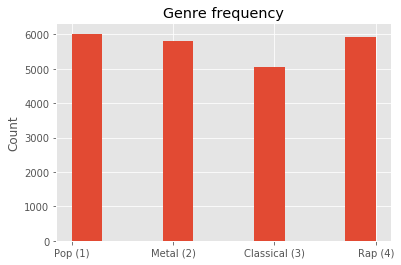

In [5]:
plt.hist(df['genre'])
plt.ylabel('Count')
plt.title('Genre frequency')
plt.xticks(np.arange(1,5,step=1),["Pop (1)","Metal (2)","Classical (3)","Rap (4)"])
plt.show()

#### Preprocessing data - removing duplicated  tracks

In [6]:
#df_tracks = shuffle(df_tracks)
grouped = df_tracks.groupby(['artist_name','track_name'], as_index=True).size()
#grouped[grouped > 1].count()
df_tracks.drop_duplicates(subset=['artist_name','track_name'], inplace=True)

# doing the same grouping as before to verify the solution
grouped_after_dropping = df_tracks.groupby(['artist_name','track_name'], as_index=True).size()
#grouped_after_dropping[grouped_after_dropping > 1].count()

df_tracks[df_tracks.duplicated(subset=['artist_name','track_name'],keep=False)].count()
df = df_tracks
#df = shuffle(df)
print("Shape after filtering: ", df.shape)


Shape after filtering:  (15253, 18)


#### The number of observations within each genre after removing duplicates

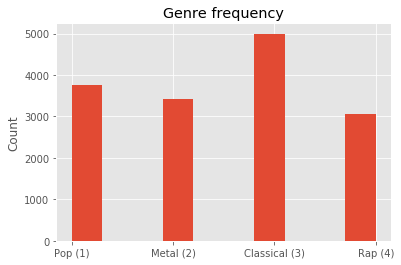

In [7]:
plt.hist(df['genre'])
plt.ylabel('Count')
plt.title('Genre frequency')
plt.xticks(np.arange(1,5,step=1),["Pop (1)","Metal (2)","Classical (3)","Rap (4)"])
plt.show()

#### Loading to csv

In [8]:
# Saving the spotify data
df.to_csv("genredatav2.csv")